# Data Import
### (original PDF file already extracted into a CSV file)

In [7]:
import re
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import pickle
import calendar

url = 'https://drive.google.com/uc?export=download&id=1w58pMLUAu5IDSu2dHbsaW0yEeK7Zc-Un'
output = 'Marine_Revenue_FY20-FY24_detail.csv'
gdown.download(url, output, quiet=False)


Downloading...
From: https://drive.google.com/uc?export=download&id=1w58pMLUAu5IDSu2dHbsaW0yEeK7Zc-Un
To: /content/Marine_Revenue_FY20-FY24_detail.csv
100%|██████████| 391k/391k [00:00<00:00, 56.2MB/s]


'Marine_Revenue_FY20-FY24_detail.csv'

# Data Cleaning Steps

### 1. Columns Containing Numeric (Fiscal) Values
For columns that contain fiscal or monetary numbers, the following cleaning steps are applied:

- Convert each value to a string and strip leading/trailing whitespace.  
- Use regular expressions to remove non-numeric symbols** such as `$`, commas, and other special characters.  
- Convert the cleaned string to a floating-point number (`float`).  
- Detect and handle parentheses indicating negative values — e.g., `(1,200)` → `-1200.0`.  
- Replace missing or unparsable values with `0.0`.


### 2. Columns Containing Month or Date Information
For columns representing months or dates, the following cleaning logic is used:

- Normalize valid month strings into a standardized `YYYY-MM` format.  
- Let pandas automatically infer the date format and return the value in `YYYY-MM-DD` format.  
- If all parsing attempts fail, return an empty string.

In [8]:
# === 0. Imports & Path ===
import re
from pathlib import Path

import pandas as pd

# === 1. Load data ===
CSV_PATH = Path("/content/Marine_Revenue_FY20-FY24_detail.csv")
df = pd.read_csv(CSV_PATH)

# === 2. Cleaning helpers ===
def clean_currency(val):
    if pd.isna(val):
        return 0.0

    s = str(val).strip()
    if s == "" or s.lower() in {"nan", "none"}:
        return 0.0

    has_paren_neg = "(" in s and ")" in s
    s = s.replace("(", "").replace(")", "")

    s = re.sub(r"[^\d.\-]", "", s)

    if s == "" or s == "-":
        return 0.0

    try:
        num = float(s)
    except ValueError:
        return 0.0

    if has_paren_neg:
        num = -abs(num)

    return num


def normalize_month(m):
    if pd.isna(m):
        return ""
    m = str(m).strip()
    try:
        return pd.to_datetime(m, errors="coerce").strftime("%Y-%m")
    except Exception:
        return m

# === 3. Apply cleaning helpers ===
money_cols = ["Revenue", "NAFI Amt", "Annual Revenue", "Annual NAFI"]
for col in money_cols:
    if col in df.columns:
        df[col] = df[col].apply(clean_currency)

df["Month"] = df["Month"].apply(normalize_month)
df["Month_parsed"] = pd.to_datetime(df["Month"], format="%b-%y", errors="coerce")


# === 4. Fill other expected columns ===
defaults = {
    "Page": 0,
    "Loc #": "",
    "Location": "",
    "Month": "",
}
for k, v in defaults.items():
    if k in df.columns:
        df[k] = df[k].fillna(v)

print("Cleaning complete!")
print(df.head(20))




Cleaning complete!
    Page Loc #           Location   Month  Revenue  NAFI Amt  Annual Revenue  \
0      2  3163  Camp Mujuk Center  Oct-17   844.00    675.20            0.00   
1      2  3163  Camp Mujuk Center  Nov-17  1048.00    838.40            0.00   
2      2  3163  Camp Mujuk Center  Dec-17   700.00    560.00            0.00   
3      2  3163  Camp Mujuk Center  Jan-18    32.00     25.60            0.00   
4      2  3163  Camp Mujuk Center  Feb-18   238.95    191.15            0.00   
5      2  3163  Camp Mujuk Center  Mar-18  1492.00   1193.60            0.00   
6      2  3163  Camp Mujuk Center  May-18   788.75    631.00            0.00   
7      2  3163  Camp Mujuk Center  Jun-18   345.00    276.00            0.00   
8      2  3163  Camp Mujuk Center  Sep-18   329.00    263.20         5817.70   
9      2  3163  Camp Mujuk Center  Oct-18    10.00      8.00            0.00   
10     2  3163  Camp Mujuk Center  Nov-18   343.00    274.40            0.00   
11     2  3163  Camp 

# Visualization Findings
we draw three plot to explore the relationship between revenue, army base loation and time.

## 1. Distribution of Numerical Columns

Number of rows and columns: (7317, 9)


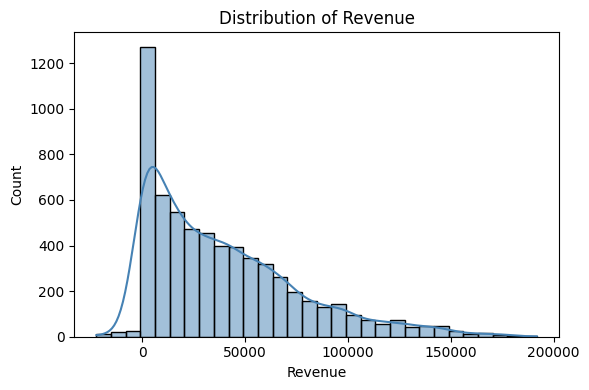

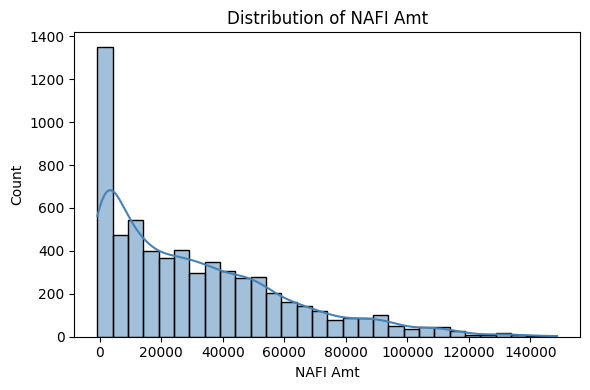

In [16]:
# === Basic Information ===
print("Number of rows and columns:", df.shape)

# === Distribution of Numerical Columns ===
num_cols = ["Revenue", "NAFI Amt"]

for col in num_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    filtered = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    plt.figure(figsize=(6,4))
    sns.histplot(filtered[col], bins=30, kde=True, color="steelblue")
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

We analyzed two numerical variables — Revenue and NAFI Amt — to understand their distribution patterns. To improve visualization, we:
- Removed outliers using the Interquartile Range (IQR) method.
- Plotted histograms with kernel density estimates (KDE) to observe distribution and skewness.

Both variables showed similar patterns. Upon further research, we found that NAFI stands for Nonappropriated Fund Instrumentality, representing funds derived from slot machine revenue (essentially a fixed proportion of the revenue). Therefore, in subsequent analyses, we focus solely on Revenue, as it sufficiently captures the underlying trends.
## 2. Revenue by Location


Top 10 Locations Summary (by mean):
                                Revenue
                                   mean
Location                               
Hangar E-Club             587766.701096
Ocean Breeze 400801       476710.895989
Taiyo Golf Course 400801  280674.368362
Iwakuni Club 401201       107840.097995
Club Iwakuni 401201       105615.281496
Torii Pines TLF 401201     80568.957045
Butler BC 400801           67218.304554
Palms 400601               59091.267871
West Pac Lodge 400801      44360.324357
West Pac Lodge             41576.796095


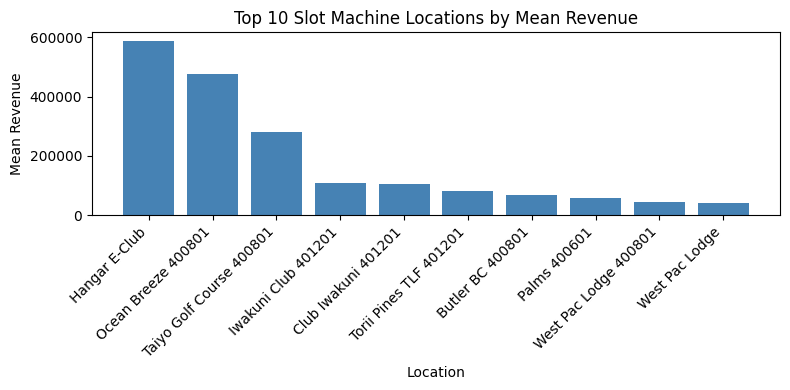

In [24]:
# === Revenue by Location ===
loc_summary = (
    df.groupby("Location")[["Revenue"]]
      .agg(["mean"])
      .sort_values(("Revenue", "mean"), ascending=False)
)

print("\nTop 10 Locations Summary (by mean):")
print(loc_summary.head(10))


# === Top 10 Locations — Mean Revenue ===
# Compute mean revenue by location and take top 10
loc_mean = (
    df.groupby("Location")["Revenue"]
      .mean()
      .sort_values(ascending=False)
)
top10_mean = loc_mean.head(10)

# Plot: single-axis bar chart of mean revenue
plt.figure(figsize=(8, 4))
x = np.arange(len(top10_mean.index))
plt.bar(x, top10_mean.values, color="steelblue")
plt.ylabel('Mean Revenue')
plt.xlabel('Location')
plt.xticks(x, top10_mean.index, rotation=45, ha='right')
plt.title('Top 10 Slot Machine Locations by Mean Revenue')
plt.tight_layout()
plt.show()

Revenue was aggregated by Location to calculate the average revenue per site. The results were sorted by mean revenue to highlight the Top 10 locations with the highest average slot machine revenue. The plot shows that the top three Marine bases have significantly higher mean slot machine revenue compared to other Army bases, suggesting a potential concentration of gambling activity at these locations.

## 3. Monthly Revenue Trend

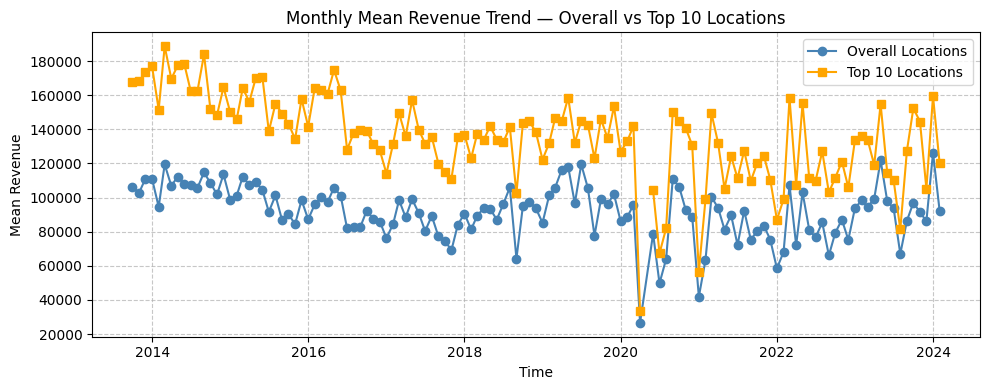

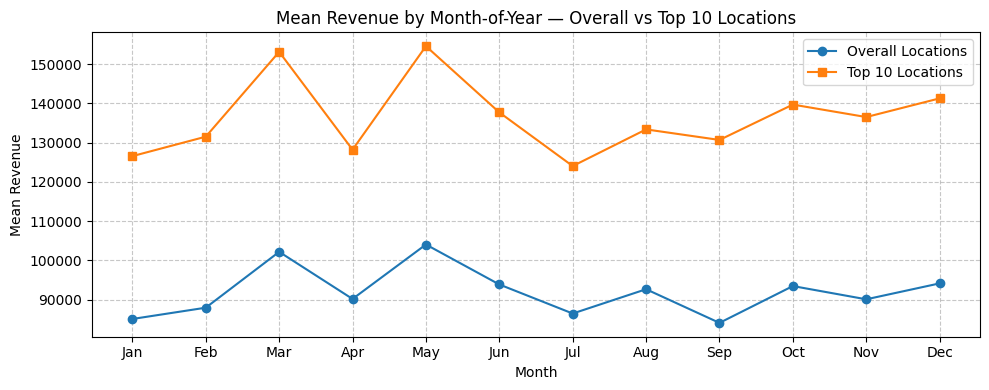

In [15]:
# === Monthly Revenue Trend ===
# Limit Data to February 2024
df_valid = df.dropna(subset=["Month_parsed"])
cutoff = pd.Timestamp("2024-03-01")
df_valid = df_valid[df_valid["Month_parsed"] < cutoff]

# Compute Mean Revenue for All Locations
monthly_all_mean = (
    df_valid.groupby("Month_parsed")[["Revenue"]]
    .mean()
    .sort_index()
)

# Select Top 10 Locations
top10_locations = (
    df.groupby("Location")[["Revenue"]]
    .sum()
    .sort_values("Revenue", ascending=False)
    .head(10)
    .index
)

df_top10 = df_valid[df_valid["Location"].isin(top10_locations)].copy()
monthly_top10_mean = (
    df_top10
    .set_index("Month_parsed")
    .groupby(pd.Grouper(freq="MS"))["Revenue"]
    .mean()
)

# Visualization
plt.figure(figsize=(10,4))
plt.plot(monthly_all_mean.index, monthly_all_mean["Revenue"], marker="o",
         label="Overall Locations", color="steelblue")
plt.plot(monthly_top10_mean.index, monthly_top10_mean.values, marker="s",
         label="Top 10 Locations", color="orange")

plt.title("Monthly Mean Revenue Trend — Overall vs Top 10 Locations")
plt.xlabel("Time")
plt.ylabel("Mean Revenue")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


# --- Month-of-Year aggregation (cross-year average) ---
df_valid_moy = df_valid.copy()
df_valid_moy["month_num"] = df_valid_moy["Month_parsed"].dt.month

# Overall: mean revenue by month-of-year
moy_overall = (
    df_valid_moy.groupby("month_num")["Revenue"]
    .mean()
    .reindex(range(1, 13))
)

# Top 10 locations: mean revenue by month-of-year
df_top10_moy = df_valid_moy[df_valid_moy["Location"].isin(top10_locations)].copy()
moy_top10 = (
    df_top10_moy.groupby("month_num")["Revenue"]
    .mean()
    .reindex(range(1, 13))
)

# Plot
month_labels = [calendar.month_abbr[m] for m in range(1, 13)]

plt.figure(figsize=(10, 4))
plt.plot(moy_overall.index, moy_overall.values, marker="o",
         label="Overall Locations")
plt.plot(moy_top10.index, moy_top10.values, marker="s",
         label="Top 10 Locations")

plt.title("Mean Revenue by Month-of-Year — Overall vs Top 10 Locations")
plt.xlabel("Month")
plt.ylabel("Mean Revenue")
plt.xticks(ticks=range(1, 13), labels=month_labels)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

This analysis helps us understand the time-based dynamics of gambling engagement across all military bases. We examined two subgroups:
- The mean monthly revenue across all locations.
- The mean monthly revenue across the Top 10 highest-revenue locations.

Two plots were generated:
- The first shows how average revenue changes over time
- The second aggregates revenue by month (across different years) to identify which months generally have higher average revenue.

The results indicate that the Top 10 bases do not differ significantly from other bases in their overall and seasonal trends. Both gambling activity among soldiers dropped sharply in 2020, likely due to the COVID-19 pandemic. There is a clear seasonal pattern — soldiers tend to gamble more in March and May, a trend that warrants further investigation.
